In [1]:
from models_and_trainers.copy_gen_transformer import CopyGeneratorTransformer

import numpy as np
import time
import math
import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, BucketIterator

from utils.useful_utils import string_split_v3, string_split_v2, string_split_v1
from utils.metrics import nltk_bleu
from utils.dataset_loaders import SRC_TGT_pairs
import utils.beam_search as beam_search
import tqdm.notebook as tqdm 

from models_and_trainers.trainers import Model_Trainer
from utils.data2dataset_fns import data2dataset_shared_vocab_with_OOVs, CustomEncode, BERTEncode
from utils.evaluate_fns import evaluate, batch_to_output_autorregressive, create_eval_fn

from utils.vocab_classes import Shared_Vocab, BERT_Vocab
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.set_device(0) # choose GPU from nvidia-smi 
print("Using:", device)

Using: cuda


In [3]:
src_train_fp = "datasets/CoNaLa/conala-train.src"
tgt_train_fp = "datasets/CoNaLa/conala-train.tgt"
src_test_fp = "datasets/CoNaLa/conala-test.src"
tgt_test_fp = "datasets/CoNaLa/conala-test.tgt"

max_seq_len = 100

train_samples = SRC_TGT_pairs(src_train_fp, tgt_train_fp, max_seq_len=max_seq_len).samples
test_samples = SRC_TGT_pairs(src_test_fp, tgt_test_fp, max_seq_len=max_seq_len).samples

In [4]:
vocab_size = 850

In [5]:
vocab = Shared_Vocab(train_samples, vocab_size, string_split_v3, use_OOVs=True)

In [6]:
encode_fn = CustomEncode(vocab)

In [7]:
train_dataset = data2dataset_shared_vocab_with_OOVs(train_samples, encode_fn, vocab)
test_dataset = data2dataset_shared_vocab_with_OOVs(test_samples, encode_fn, vocab)

In [8]:
batch_size = 32

train_iterator = BucketIterator(
    train_dataset,
    batch_size = batch_size,
    repeat=True,
    shuffle=True,
    sort=True,
    sort_key = lambda x: len(x.src)+len(x.tgt),
    device = device)

test_iterator = BucketIterator(
    test_dataset,
    batch_size = batch_size,
    sort=True,
    sort_key = lambda x: len(x.src)+len(x.tgt),
    device = device)

In [9]:
sample = next(iter(train_dataset))
vocab.decode_input(sample.tgt, sample.OOVs)

'sum ( d * 10 * * i for i , d in enumerate ( x [ : : - 1 ] ) )'

In [10]:
for i, batch in enumerate(train_iterator):
    for idx in range(batch_size):
        encoder_input = batch.src.cpu()[:,idx].tolist()
        decoder_input = batch.tgt.cpu()[:,idx].tolist()
        OOVs = batch.OOVs.cpu()[:,idx].tolist()

        print("encoder_input    :",vocab.decode_input(encoder_input, OOVs))
        print("decoder_input    :",vocab.decode_output(decoder_input, OOVs))
        print()
        break
    break

encoder_input    : <sos> reverse a list ` array ` <eos>
decoder_input    : <sos> reversed ( array ) <eos> <pad> <pad>



In [11]:
output_vocab_size = vocab.size+max_seq_len
model = CopyGeneratorTransformer(vocab_size=output_vocab_size, embed_dim=512, att_heads=8, layers=4, dim_feedforward=1024).to(device)

In [12]:
output_vocab_size

950

In [13]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi['<pad>'])
params = model.parameters()

def train_step(batch):
    total_loss = 0.
    start_time = time.time()
    encoder_input = batch.src
    decoder_input = batch.tgt[:-1]
    targets = batch.tgt[1:]

    optimizer.zero_grad()
    output = model(encoder_input, decoder_input)

    loss = criterion(output.view(-1, output_vocab_size), targets.view(-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(params, 0.5)
    optimizer.step()
    elapsed = time.time() - start_time
    return loss

In [14]:
def batch_filter_ids(batch_list):
    SOS_token=vocab.stoi["<sos>"]
    EOS_token=vocab.stoi["<eos>"]
    PAD_token=vocab.stoi["<pad>"]
    return [[id for id in l if id not in [SOS_token,EOS_token,PAD_token]] for l in batch_list]

def evaluate(iterator):
    model.eval() # Turn on the evaluation mode
    with torch.no_grad(), open("BERT_code_generator.out", "w", encoding="utf-8") as out_fp:
        BLEU_scores = []
        pbar = tqdm.tqdm(enumerate(iterator), total=len(iterator))
        for i, batch in pbar:
            batch_size = batch.src.shape[1]
            
            encoder_inputs = batch.src
            predictions = beam_search.beam_search_decode(model,
                              batch_encoder_ids=encoder_inputs,
                              SOS_token=vocab.stoi["<sos>"],
                              EOS_token=vocab.stoi["<eos>"],
                              PAD_token=vocab.stoi["<pad>"],
                              beam_size=1,
                              max_length=max_seq_len,
                              num_out=1)
            
            sources = encoder_inputs.transpose(0,1).cpu().tolist()
            sources = batch_filter_ids(sources)
            
            predictions = [t[0].view(-1).cpu().tolist() for t in predictions]
            predictions = batch_filter_ids(predictions)
            
            targets = batch.tgt.transpose(0,1).cpu().tolist()
            targets = batch_filter_ids(targets)
            
            for j in range(batch_size):
                BLEU = nltk_bleu(targets[j], predictions[j])
                BLEU_scores.append(BLEU)
                OOV_ids = batch.OOVs.cpu()[:,idx].tolist()
                
                out_fp.write("SRC  :" + vocab.decode(sources[j],OOV_ids) + "\n")
                out_fp.write("TGT  :" + vocab.decode(targets[j],OOV_ids) + "\n")
                out_fp.write("PRED :" + vocab.decode(predictions[j],OOV_ids) + "\n")
                out_fp.write("BLEU :" + str(BLEU) + "\n")
                out_fp.write("\n")
            pbar.set_description(f"BLEU:{np.average(BLEU_scores):5.2f}")
        final_BLEU = np.average(BLEU_scores)
        
        out_fp.write("\n\n| EVALUATION | BLEU: {:5.2f} |\n".format(final_BLEU))
        print("| EVALUATION | BLEU: {:5.3f} |".format(final_BLEU))
    return (final_BLEU)

In [15]:
eval_fn = create_eval_fn(model, 
                         test_iterator, 
                         batch_to_output_autorregressive, 
                         vocab, 
                         out_file="small_transformer_Custom_tokenizer_CoNaLa.out", 
                         max_seq_len=100)

In [16]:
lr = 0.005 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

trainer = Model_Trainer(optimizer, scheduler)

AttributeError: 'SGD' object has no attribute 'stats'

In [ ]:
scores = trainer.train(model,train_iterator,train_step,500000,eval_fn=eval_fn, eval_interval=10000)

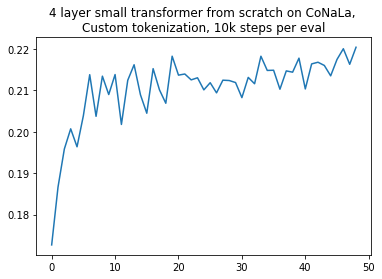

In [29]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title("4 layer small transformer from scratch on CoNaLa, \nCustom tokenization, 10k steps per eval")
plt.show()

## Performance profiling

In [37]:
def func1():
    a = 3
    time.sleep(0.1)
    return a
    
def func2():
    b = "foo"
    c = func1()
    return c

In [17]:
%lprun -f model.transformer.forward trainer.train(model,train_iterator,train_step,50) 

Finished training


Timer unit: 1e-06 s

Total time: 0.529808 s
File: /nfs/phd_by_carlos/notebooks/models_and_trainers/exposed_transformer.py
Function: forward at line 73

Line #      Hits         Time  Per Hit   % Time  Line Contents
    73                                               def forward(self, src, tgt, src_mask=None, tgt_mask=None,
    74                                                           memory_mask=None, src_key_padding_mask=None,
    75                                                           tgt_key_padding_mask=None, memory_key_padding_mask=None):
    76                                                   r"""Take in and process masked source/target sequences.
    77                                           
    78                                                   Args:
    79                                                       src: the sequence to the encoder (required).
    80                                                       tgt: the sequence to the decoder (required).
   

In [56]:
it = iter(train_iterator)

In [52]:
%lprun -f model.forward train_step(batch) 

Timer unit: 1e-06 s

Total time: 0.14072 s
File: /nfs/phd_by_carlos/notebooks/models_and_trainers/copy_gen_transformer.py
Function: forward at line 202

Line #      Hits         Time  Per Hit   % Time  Line Contents
   202                                               def forward(self, src, tgt):
   203         1      49978.0  49978.0     35.5          self.tgt_mask = self._generate_square_subsequent_mask(len(tgt)).to(self.device) if self.masked_look_ahead_att else None
   204                                                   
   205                                           
   206         1        993.0    993.0      0.7          src_emb = self.src_embedder(src) * math.sqrt(self.embedding_size)
   207                                                   
   208         1       1350.0   1350.0      1.0          tgt_emb = self.tgt_embedder(tgt) * math.sqrt(self.embedding_size)
   209                                                   
   210         1      86841.0  86841.0     61.7        

In [30]:
evaluate(test_iterator)


| EVALUATION | BLEU: 0.233 |


0.23335973817926922

In [28]:
evaluate(model, test_iterator, batch_to_output_autorregressive, vocab)


| EVALUATION | BLEU: 0.233 |


0.23340242687774862

# Using updated classes for modularity

In [1]:
from models_and_trainers.autoregressive_transformer import AutoregressiveTransformer
from utils.dataset_loaders import SRC_TGT_pairs
from utils.vocab_classes import Shared_Vocab, BERT_Vocab
from utils.useful_utils import string_split_v3, string_split_v2, string_split_v1
from models_and_trainers.trainers import Model_Trainer
from models_and_trainers.retrieval import PyLuceneRetriever
import torch
import torch.nn as nn
from torchtext.data import Field, BucketIterator

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.set_device(0) # choose GPU from nvidia-smi 
print("Using:", device)

Using: cuda


In [2]:
max_seq_len = 50
vocab_size = 850
batch_size = 32
embed_dim = 512
att_heads = 8
layers = 4
dim_feedforward = 1024
steps = 500000
save_interval=2000
eval_interval=400
log_interval = 100
lr = 0.005
eval_file = "model_eval_outputs.txt"

src_train_fp = "datasets/django_folds/django.fold1-10.train.src"
tgt_train_fp = "datasets/django_folds/django.fold1-10.train.tgt"
src_test_fp = "datasets/django_folds/django.fold1-10.test.src"
tgt_test_fp = "datasets/django_folds/django.fold1-10.test.tgt"

In [3]:
train_samples = SRC_TGT_pairs(src_train_fp, tgt_train_fp, max_seq_len=max_seq_len).samples
test_samples = SRC_TGT_pairs(src_test_fp, tgt_test_fp, max_seq_len=max_seq_len).samples

In [8]:
retriever = PyLuceneRetriever()
src_train_data = [src for src,tgt in train_samples]
retriever.add_multiple_docs(src_train_data)

train_samples = retriever.augment_src_with_retrieval(train_samples,train_samples, rank_return=1)
test_samples = retriever.augment_src_with_retrieval(test_samples,train_samples, rank_return=0)

JVM Running


In [13]:
test_samples[0]

('from threading import local into default name space. <CODE> from threading import local',
 'from threading import local')

In [4]:
vocab = Shared_Vocab(train_samples, vocab_size, string_split_v3, use_OOVs=True)

In [5]:
model = AutoregressiveTransformer(vocab_size=vocab_size, embed_dim=embed_dim, att_heads=att_heads, \
                                  layers=layers, dim_feedforward=dim_feedforward).to(device)
model.init_train_params(vocab, lr=lr)

In [6]:
train_dataset = model.data2dataset(train_samples, vocab)
test_dataset = model.data2dataset(test_samples, vocab)

train_iterator = BucketIterator(
    train_dataset,
    batch_size = batch_size,
    repeat=True,
    shuffle=True,
    sort=True,
    sort_key = model.sample_order_fn,
    device = device)

test_iterator = BucketIterator(
    test_dataset,
    batch_size = batch_size,
    sort=True,
    sort_key = model.sample_order_fn,
    device = device)

In [7]:
trainer = Model_Trainer(model, vocab, test_iterator=test_iterator, eval_file=eval_file)

In [8]:
trainer.train(model, train_iterator, steps, log_interval=log_interval, eval_interval=eval_interval, \
              save_interval=save_interval)

Evaluating model



sample_BLEU:0.04460608202004834
Evaluating model



sample_BLEU:0.16494347550121205
Evaluating model



sample_BLEU:0.25489014684604977
Evaluating model



sample_BLEU:0.2779596419854888
Evaluating model



sample_BLEU:0.22510659825888235
Evaluating model



sample_BLEU:0.34211886986795614
Keyboard Interrupt!


{'train_loss': [2.105891607999802,
  2.668328070640564,
  2.6332431507110594,
  2.9204950976371764,
  3.243947837352753,
  1.809476807117462,
  1.8081236803531646,
  1.9365714138746262,
  2.254199267625809,
  2.692099199295044,
  1.8836085060238839,
  1.2377749347686768,
  1.4642055082321166,
  1.8264257127046586,
  2.230433555841446,
  2.2596227480471134,
  0.7450432160496712,
  1.1485367369651795,
  1.4164473456144333,
  1.9218704628944396,
  2.6256325888633727,
  0.42888784989714623,
  1.0191342306137086,
  1.1184586790204047,
  1.6350519341230392,
  2.254453345537186,
  0.9546155657246709],
 'eval_scores': [{'step': 400, 'sample_BLEU': 0.04460608202004834},
  {'step': 800, 'sample_BLEU': 0.16494347550121205},
  {'step': 1200, 'sample_BLEU': 0.25489014684604977},
  {'step': 1600, 'sample_BLEU': 0.2779596419854888},
  {'step': 2000, 'sample_BLEU': 0.22510659825888235},
  {'step': 2400, 'sample_BLEU': 0.34211886986795614}]}